In [1]:
# 텐서플로우 일일 빌드버전

pip install -q tf-nightly

     |████████████████████████████████| 492.7 MB 9.1 kB/s 
     |████████████████████████████████| 1.4 MB 44.9 MB/s 
     |████████████████████████████████| 462 kB 75.9 MB/s 
     |████████████████████████████████| 5.8 MB 21.5 MB/s 


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
# pathlib를 통해 경로관리 편하게

import pathlib

path = pathlib.Path('/content/drive/MyDrive/T1_PJ/DATA/생활 폐기물 이미지/Training/이미지 폴더')

In [66]:
path

PosixPath('/content/drive/MyDrive/T1_PJ/DATA/생활 폐기물 이미지/Training/이미지 폴더')

In [67]:
# 해당경로 하위에 있는 jpg 파일 개수 알아보기

image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

17889


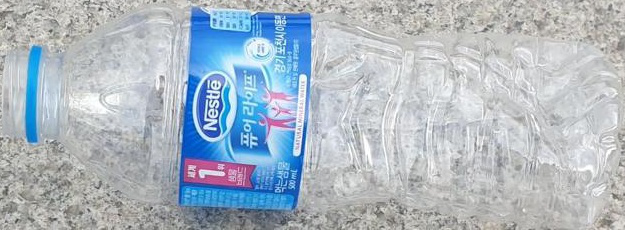

In [68]:
# 해당위치의 첫번째 데이터

PET = list(path.glob('페트_페트병/*'))
PIL.Image.open(str(PET[0]))

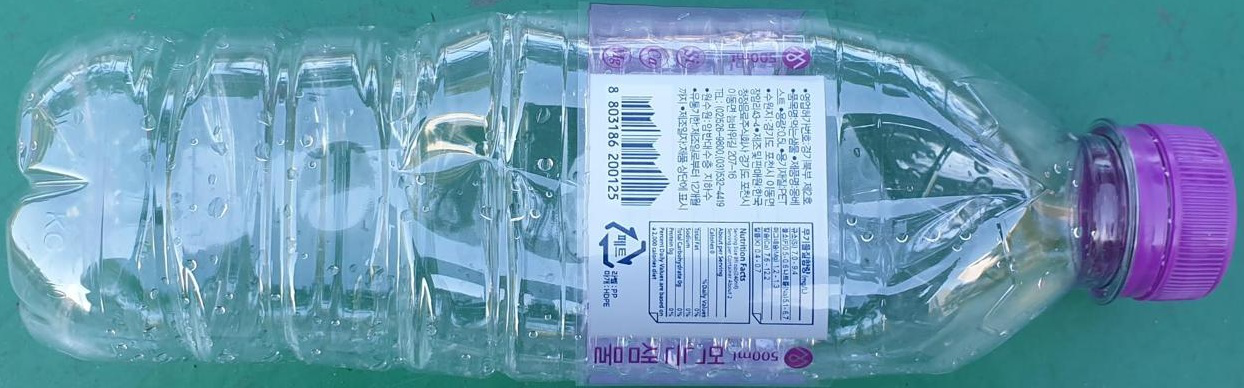

In [69]:
PIL.Image.open(str(PET[1]))

In [70]:
# 배치사이즈

batch_size = 32

In [71]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size)

Found 17889 files belonging to 2 classes.
Using 14312 files for training.


In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Found 17889 files belonging to 2 classes.
Using 3577 files for validation.


In [73]:
class_names = train_ds.class_names
print(class_names)

['음료수잔', '페트_페트병']


In [74]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [75]:
# 정규화 작업

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [76]:
# 정규화 작업

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.082022816 1.0


In [77]:
# 모델 작성
# 
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [78]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

In [80]:
# 훈련

epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
448/448 [==============================] - 3097s 7s/step - loss: 0.3535 - accuracy: 0.8533 - val_loss: 0.3012 - val_accuracy: 0.8613
Epoch 2/10
448/448 [==============================] - 920s 2s/step - loss: 0.2811 - accuracy: 0.8822 - val_loss: 0.3012 - val_accuracy: 0.8857
Epoch 3/10
448/448 [==============================] - 915s 2s/step - loss: 0.2464 - accuracy: 0.9005 - val_loss: 0.2691 - val_accuracy: 0.9033
Epoch 4/10
448/448 [==============================] - 912s 2s/step - loss: 0.2265 - accuracy: 0.9080 - val_loss: 0.2926 - val_accuracy: 0.8801
Epoch 5/10
448/448 [==============================] - 914s 2s/step - loss: 0.1972 - accuracy: 0.9195 - val_loss: 0.2730 - val_accuracy: 0.9142
Epoch 6/10
448/448 [==============================] - 915s 2s/step - loss: 0.1570 - accuracy: 0.9352 - val_loss: 0.2612 - val_accuracy: 0.9097
Epoch 7/10
448/448 [==============================] - 913s 2s/step - loss: 0.1312 - accuracy: 0.9465 - val_loss: 0.2930 - val_accuracy: 0.912

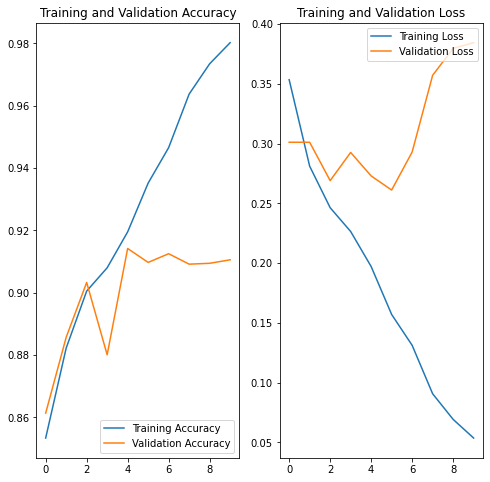

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()